Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with SC.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [3]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [4]:
# Set up and run a campaign
def run_campaign(sc_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_sc.')

    # Define parameter space
    params = {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=params, actions=actions)

    # Create the sampler
    vary = {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=sc_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute().collate()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

In [7]:
R = {}
for sc_order in range(1, 11):  # 21
    R[sc_order] = {}
    (R[sc_order]['results_df'], 
     R[sc_order]['results'], 
     R[sc_order]['times'], 
     R[sc_order]['order'], 
     R[sc_order]['number_of_samples']) = run_campaign(sc_order=sc_order, use_files=False)

Time for phase 1 = 0.064
Number of samples = 8
Time for phase 2 = 0.111
Time for phase 3 = 0.022
Time for phase 4 = 0.007
Time for phase 5 = 0.053
Time for phase 6 = 0.009
Time for phase 1 = 0.023
Number of samples = 27
Time for phase 2 = 0.181
Time for phase 3 = 0.039
Time for phase 4 = 0.006
Time for phase 5 = 0.068
Time for phase 6 = 0.002
Time for phase 1 = 0.024
Number of samples = 64
Time for phase 2 = 0.310
Time for phase 3 = 0.076
Time for phase 4 = 0.007
Time for phase 5 = 0.153
Time for phase 6 = 0.003
Time for phase 1 = 0.025
Number of samples = 125
Time for phase 2 = 0.488
Time for phase 3 = 0.143
Time for phase 4 = 0.011
Time for phase 5 = 0.302
Time for phase 6 = 0.002
Time for phase 1 = 0.026
Number of samples = 216
Time for phase 2 = 0.689
Time for phase 3 = 0.241
Time for phase 4 = 0.022
Time for phase 5 = 0.524
Time for phase 6 = 0.004
Time for phase 1 = 0.026
Number of samples = 343
Time for phase 2 = 0.973
Time for phase 3 = 0.362
Time for phase 4 = 0.029
Time for p

In [8]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [9]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.266940,0.063798,0.111396,0.022494,0.006757,0.053020,0.008592
2,0.320724,0.023100,0.181087,0.039353,0.006465,0.067616,0.001642
3,0.574892,0.024012,0.309771,0.075512,0.007160,0.153073,0.002812
4,0.975655,0.025482,0.488014,0.142628,0.010991,0.301583,0.001883
5,1.505375,0.025882,0.688701,0.240946,0.022248,0.523602,0.003606
6,2.226374,0.026346,0.973210,0.362254,0.029219,0.828651,0.006294
7,3.414736,0.028358,1.308445,0.733479,0.023383,1.300429,0.007564
8,4.454620,0.030842,1.747718,0.736547,0.042625,1.873106,0.008427
9,5.979308,0.027360,2.247586,1.159033,0.040416,2.477814,0.009468
10,7.709540,0.029629,2.745019,1.275154,0.065694,3.577087,0.011467


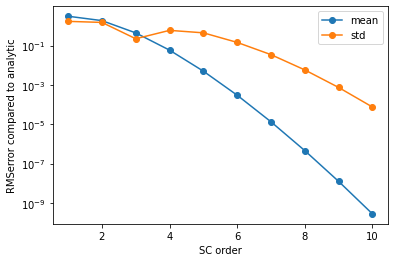

In [10]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('SC order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

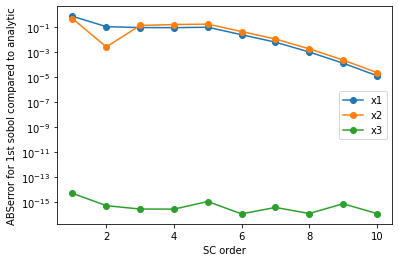

In [11]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('SC order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

In [14]:
_o = []
_RMS = []
for r in R.values():
    results_df = r['results_df']
    results = r['results']
    Ishigami_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))
    Ishigami_samples = np.squeeze(np.array(results_df['Ishigami']))
    _RMS.append((np.sqrt((((Ishigami_surrogate - Ishigami_samples) / Ishigami_samples)**2).mean())))
    _o.append(r['order'])

In [41]:
F = results.surrogate()
F(results_df[results.inputs])

{'Ishigami': 0.0}

In [42]:
results_df[results.inputs]

,x1,x2,x3
,0,0,0
0,-3.073196,-3.073196,-3.073196
1,-3.073196,-3.073196,-2.786789
2,-3.073196,-3.073196,-2.293840
3,-3.073196,-3.073196,-1.630789
4,-3.073196,-3.073196,-0.846795
...,...,...,...
1326,3.073196,3.073196,0.846795
1327,3.073196,3.073196,1.630789
1328,3.073196,3.073196,2.293840


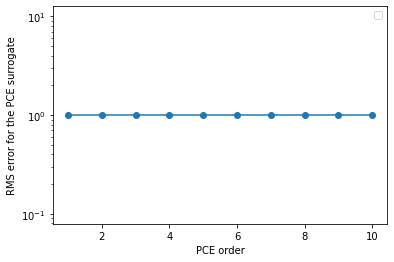

In [15]:
plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
#plt.savefig('Convergence_surrogate.png')
#plt.savefig('Convergence_surrogate.pdf')